# Catan PPO — Training Visualisation
Loads `checkpoints/training_state.pkl` and plots all key metrics so you can judge whether training is healthy.

In [22]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

CHECKPOINT = "checkpoints/training_state.pkl"
NUM_PLAYERS = 4
COLORS = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]  # one per player
SMOOTH = 20   # rolling-window size for smoothed curves

with open(CHECKPOINT, "rb") as f:
    data = pickle.load(f)

episode_rewards = data["episode_rewards"]   # list[list[float]]  shape (4, N)
win_buf         = data["win_buf"]           # list[int]  -1 = timeout
turn_buf        = data["turn_buf"]          # list[int]
vp_buf          = data["vp_buf"]            # list[list[float]]  shape (4, N)
loss_buf        = data["loss_buf"]          # {"policy": [], "value": [], "entropy": []}

N = len(win_buf)
eps = np.arange(1, N + 1)
print(f"Loaded {N} episodes from '{CHECKPOINT}'")


def smooth(arr, w=SMOOTH):
    """Simple centred rolling mean."""
    arr = np.asarray(arr, dtype=float)
    if len(arr) < w:
        return arr
    kernel = np.ones(w) / w
    return np.convolve(arr, kernel, mode="valid")

Loaded 1500 episodes from 'checkpoints/training_state.pkl'


## 1 · Win Rates
Rolling win rate per player and timeout rate over training. Healthy training: win rates diverge and timeout rate falls.

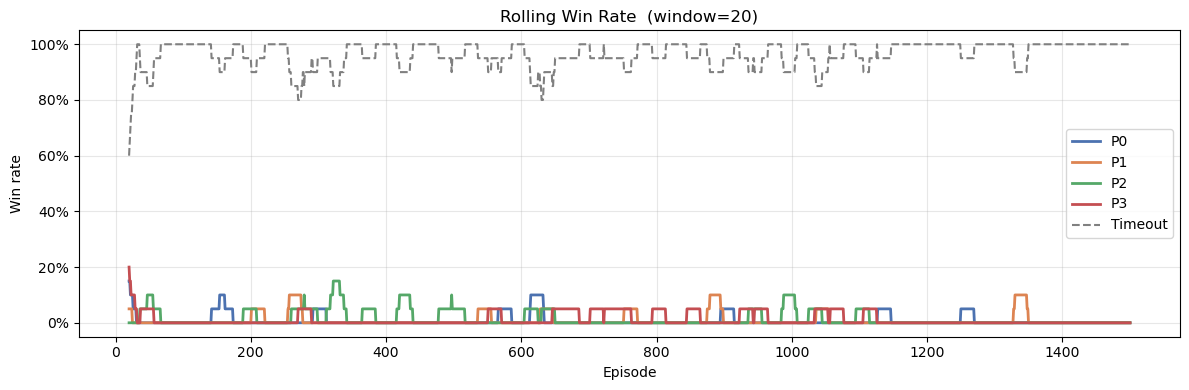

In [16]:
W = SMOOTH
fig, ax = plt.subplots(figsize=(12, 4))

for i in range(NUM_PLAYERS):
    wins_i = np.array([1.0 if w == i else 0.0 for w in win_buf])
    s = smooth(wins_i, W)
    x = eps[W - 1:]
    ax.plot(x, s, color=COLORS[i], label=f"P{i}", linewidth=2)

timeouts = np.array([1.0 if w == -1 else 0.0 for w in win_buf])
s = smooth(timeouts, W)
ax.plot(eps[W - 1:], s, color="grey", linestyle="--", label="Timeout", linewidth=1.5)

ax.set_title(f"Rolling Win Rate  (window={W})")
ax.set_xlabel("Episode")
ax.set_ylabel("Win rate")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2 · Average Victory Points at Game End
Shows whether agents are actually building things. Should rise above 2 (setup-only baseline) as training progresses.

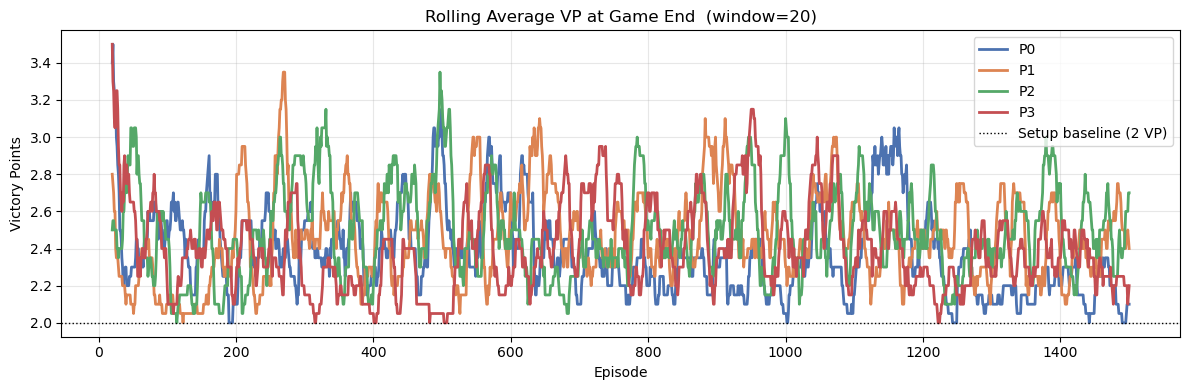

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

for i in range(NUM_PLAYERS):
    vps = np.array(vp_buf[i], dtype=float)
    s   = smooth(vps, SMOOTH)
    ax.plot(eps[SMOOTH - 1:], s, color=COLORS[i], label=f"P{i}", linewidth=2)

# Baseline: 2 VP = just setup settlements
ax.axhline(2, color="black", linestyle=":", linewidth=1, label="Setup baseline (2 VP)")

ax.set_title(f"Rolling Average VP at Game End  (window={SMOOTH})")
ax.set_xlabel("Episode")
ax.set_ylabel("Victory Points")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3 · Game Length Over Time
Should decrease as agents get better and win faster rather than timing out at `max_turns=300`.

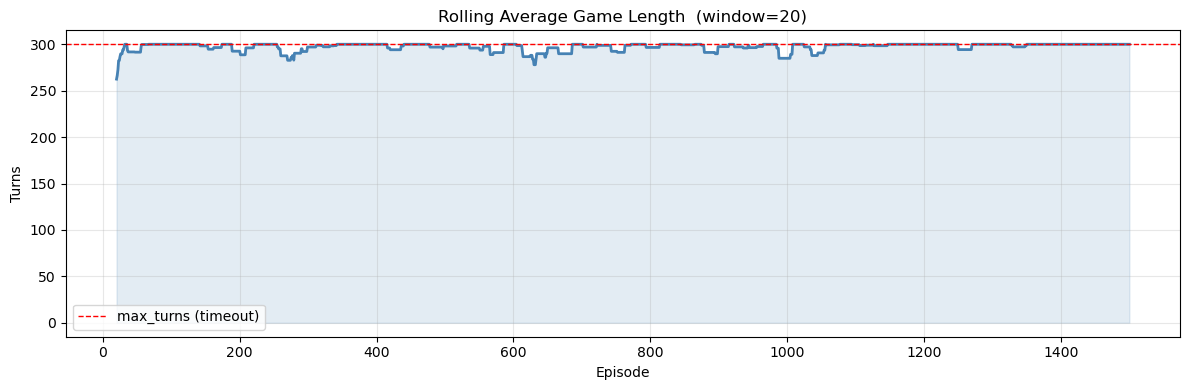

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

turns = np.array(turn_buf, dtype=float)
s     = smooth(turns, SMOOTH)
ax.plot(eps[SMOOTH - 1:], s, color="steelblue", linewidth=2)
ax.fill_between(eps[SMOOTH - 1:], s, alpha=0.15, color="steelblue")
ax.axhline(300, color="red", linestyle="--", linewidth=1, label="max_turns (timeout)")

ax.set_title(f"Rolling Average Game Length  (window={SMOOTH})")
ax.set_xlabel("Episode")
ax.set_ylabel("Turns")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4 · Cumulative Reward per Player
Total reward accumulated per episode (smoothed). All players at the same flat value = policy collapse.

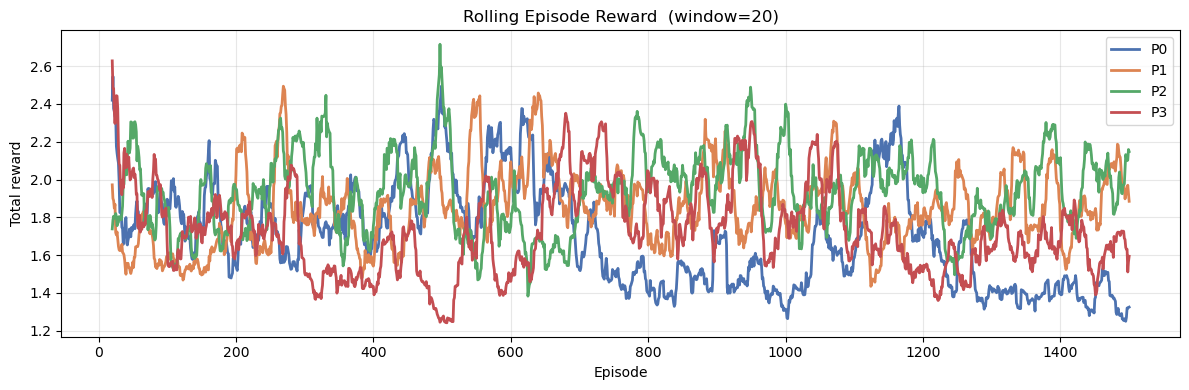

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))

for i in range(NUM_PLAYERS):
    rew = np.array(episode_rewards[i], dtype=float)
    s   = smooth(rew, SMOOTH)
    ax.plot(eps[SMOOTH - 1:], s, color=COLORS[i], label=f"P{i}", linewidth=2)

ax.set_title(f"Rolling Episode Reward  (window={SMOOTH})")
ax.set_xlabel("Episode")
ax.set_ylabel("Total reward")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5 · PPO Health: Policy Loss, Value Loss, Entropy
**Entropy** is the most important: if it drops near 0, the policy has collapsed. Policy loss should be near 0; value loss should decrease over time.

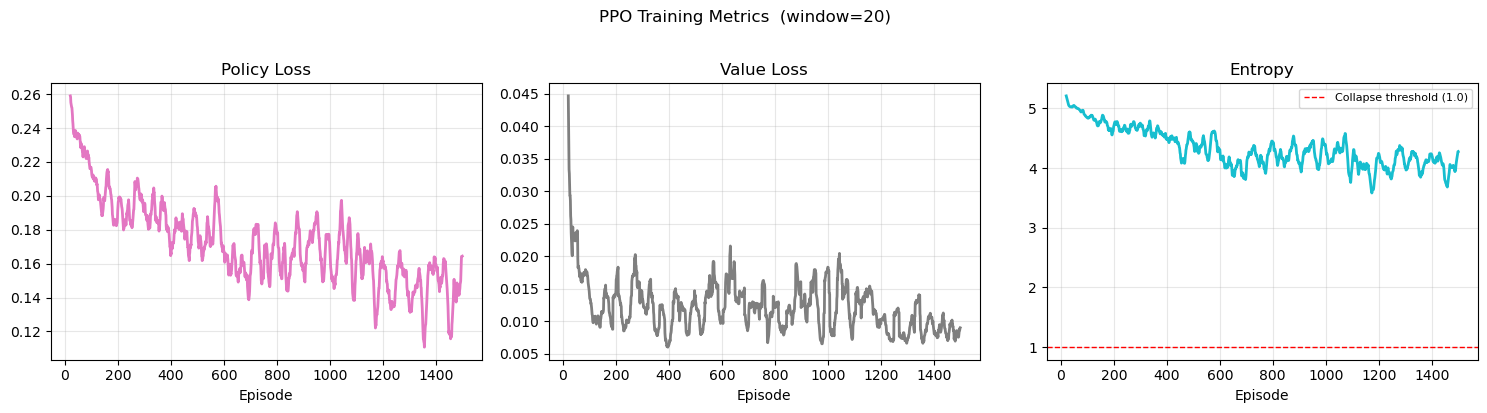

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

labels   = ["Policy Loss", "Value Loss", "Entropy"]
keys     = ["policy",      "value",      "entropy"]
clrs     = ["#E377C2",     "#7F7F7F",    "#17BECF"]
warnings = [None, None, 1.0]  # entropy < 1.0 is a warning

for ax, lbl, key, clr, warn in zip(axes, labels, keys, clrs, warnings):
    data_raw = np.array(loss_buf[key], dtype=float)
    s = smooth(data_raw, SMOOTH)
    x = eps[SMOOTH - 1:]
    ax.plot(x, s, color=clr, linewidth=2)
    if warn is not None:
        ax.axhline(warn, color="red", linestyle="--", linewidth=1, label=f"Collapse threshold ({warn})")
        ax.legend(fontsize=8)
    ax.set_title(lbl)
    ax.set_xlabel("Episode")
    ax.grid(alpha=0.3)

plt.suptitle(f"PPO Training Metrics  (window={SMOOTH})", y=1.02)
plt.tight_layout()
plt.show()

## 6 · Overall Training Summary
Final-window statistics in one table: win rate, avg VP, avg reward, and total wins.

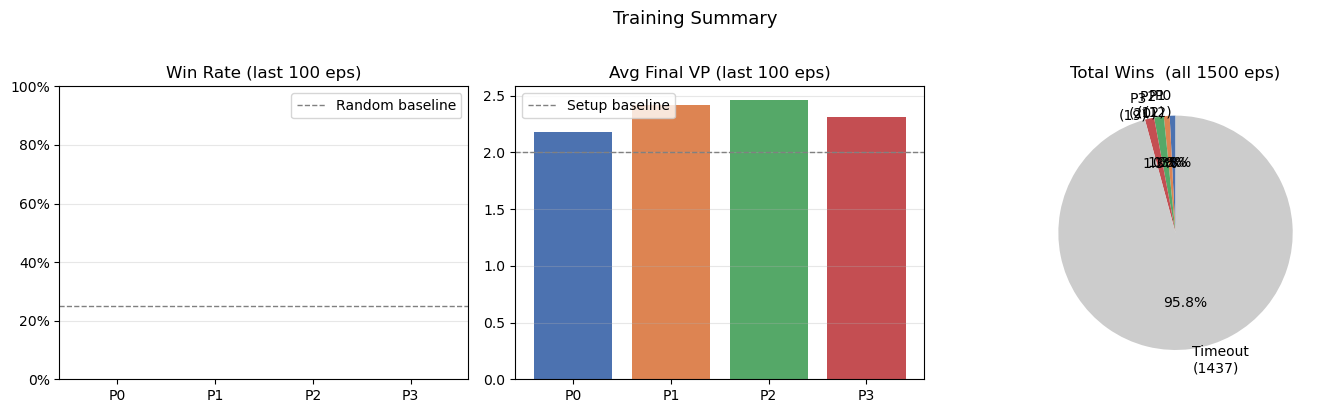


Player      WinRate  TotalWins    AvgVP  AvgReward
----------------------------------------------------
P0             0.0%         12     2.18     +1.384
P1             0.0%         12     2.42     +1.890
P2             0.0%         20     2.46     +1.987
P3             0.0%         19     2.31     +1.656

Total episodes: 1500   Timeouts: 1437 (95.8%)
Avg entropy (last 100): 4.0527  ✓ OK


In [21]:
W_LAST = min(100, N)   # use last 100 episodes for the summary

win_rates  = [win_buf[-W_LAST:].count(i) / W_LAST for i in range(NUM_PLAYERS)]
total_wins = [win_buf.count(i)                     for i in range(NUM_PLAYERS)]
avg_vp     = [np.mean(vp_buf[i][-W_LAST:])         for i in range(NUM_PLAYERS)]
avg_rew    = [np.mean(episode_rewards[i][-W_LAST:]) for i in range(NUM_PLAYERS)]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Win rate bar chart
axes[0].bar([f"P{i}" for i in range(NUM_PLAYERS)], win_rates, color=COLORS)
axes[0].axhline(0.25, color="grey", linestyle="--", linewidth=1, label="Random baseline")
axes[0].set_title(f"Win Rate (last {W_LAST} eps)")
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Avg VP bar chart
axes[1].bar([f"P{i}" for i in range(NUM_PLAYERS)], avg_vp, color=COLORS)
axes[1].axhline(2, color="grey", linestyle="--", linewidth=1, label="Setup baseline")
axes[1].set_title(f"Avg Final VP (last {W_LAST} eps)")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

# Total wins pie chart
labels_pie = [f"P{i}\n({total_wins[i]})" for i in range(NUM_PLAYERS)]
timeouts   = win_buf.count(-1)
sizes      = total_wins + [timeouts]
clrs_pie   = COLORS + ["#CCCCCC"]
labels_pie = labels_pie + [f"Timeout\n({timeouts})"]
axes[2].pie(sizes, labels=labels_pie, colors=clrs_pie, autopct="%1.1f%%", startangle=90)
axes[2].set_title(f"Total Wins  (all {N} eps)")

plt.suptitle("Training Summary", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Print table
print(f"\n{'Player':<8} {'WinRate':>10} {'TotalWins':>10} {'AvgVP':>8} {'AvgReward':>10}")
print("-" * 52)
for i in range(NUM_PLAYERS):
    print(f"P{i:<7} {win_rates[i]:>10.1%} {total_wins[i]:>10d} {avg_vp[i]:>8.2f} {avg_rew[i]:>+10.3f}")
print(f"\nTotal episodes: {N}   Timeouts: {timeouts} ({timeouts/N:.1%})")
print(f"Avg entropy (last {W_LAST}): {np.mean(loss_buf['entropy'][-W_LAST:]):.4f}"
      + ("  ⚠ LOW — policy may have collapsed" if np.mean(loss_buf['entropy'][-W_LAST:]) < 1.0 else "  ✓ OK"))

## 7 · Entropy Deep-Dive
Entropy is the single most important collapse indicator. A healthy policy keeps entropy well above 1.0. If it trends toward 0 the agent has memorised a fixed (likely passive) strategy and exploration has collapsed.

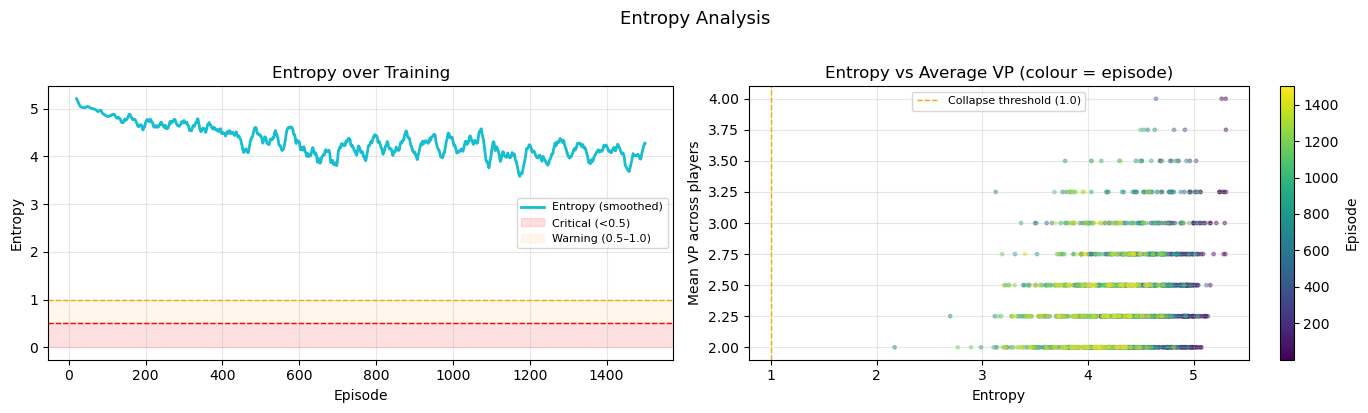

Entropy quartile means:
  Q1 (ep 1–375): 4.7726
  Q2 (ep 376–750): 4.2717
  Q3 (ep 751–1125): 4.2149
  Q4 (ep 1126–1500): 4.0617

Final 100-ep mean entropy : 4.0527  ✓ OK


In [23]:
entropy_arr = np.array(loss_buf["entropy"], dtype=float)
policy_arr  = np.array(loss_buf["policy"],  dtype=float)
value_arr   = np.array(loss_buf["value"],   dtype=float)

COLLAPSE_THRESH = 1.0
CRITICAL_THRESH = 0.5

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ── Left: raw entropy with collapse/critical bands ──────────────────
s_ent = smooth(entropy_arr, SMOOTH)
x_ent = eps[SMOOTH - 1:]

axes[0].plot(x_ent, s_ent, color="#17BECF", linewidth=2, label="Entropy (smoothed)")
axes[0].axhspan(0, CRITICAL_THRESH, alpha=0.12, color="red",    label=f"Critical (<{CRITICAL_THRESH})")
axes[0].axhspan(CRITICAL_THRESH, COLLAPSE_THRESH, alpha=0.08,
                color="orange", label=f"Warning ({CRITICAL_THRESH}–{COLLAPSE_THRESH})")
axes[0].axhline(COLLAPSE_THRESH, color="orange", linestyle="--", linewidth=1)
axes[0].axhline(CRITICAL_THRESH, color="red",    linestyle="--", linewidth=1)

# Mark when entropy first crossed collapse threshold
collapsed_steps = np.where(s_ent < COLLAPSE_THRESH)[0]
if len(collapsed_steps):
    first_collapse = x_ent[collapsed_steps[0]]
    axes[0].axvline(first_collapse, color="orange", linestyle=":", linewidth=1.5,
                    label=f"First <{COLLAPSE_THRESH} @ ep {first_collapse}")

axes[0].set_title("Entropy over Training")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Entropy")
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

# ── Right: entropy vs VP scatter (per episode) ───────────────────────
mean_vp_per_ep = np.mean([np.array(vp_buf[i]) for i in range(NUM_PLAYERS)], axis=0)
axes[1].scatter(entropy_arr, mean_vp_per_ep, c=eps, cmap="viridis",
                s=6, alpha=0.4)
sm = plt.cm.ScalarMappable(cmap="viridis",
                            norm=plt.Normalize(vmin=eps[0], vmax=eps[-1]))
sm.set_array([])
fig.colorbar(sm, ax=axes[1], label="Episode")
axes[1].axvline(COLLAPSE_THRESH, color="orange", linestyle="--", linewidth=1,
                label=f"Collapse threshold ({COLLAPSE_THRESH})")
axes[1].set_title("Entropy vs Average VP (colour = episode)")
axes[1].set_xlabel("Entropy")
axes[1].set_ylabel("Mean VP across players")
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.suptitle("Entropy Analysis", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Summary stats
quarters = np.array_split(entropy_arr, 4)
print("Entropy quartile means:")
for q_idx, q in enumerate(quarters):
    label = "  ⚠ LOW" if q.mean() < COLLAPSE_THRESH else ""
    print(f"  Q{q_idx+1} (ep {q_idx*(N//4)+1}–{(q_idx+1)*(N//4)}): {q.mean():.4f}{label}")
print(f"\nFinal {W_LAST}-ep mean entropy : {entropy_arr[-W_LAST:].mean():.4f}"
      + ("  ⛔ COLLAPSED" if entropy_arr[-W_LAST:].mean() < CRITICAL_THRESH
         else ("  ⚠ LOW" if entropy_arr[-W_LAST:].mean() < COLLAPSE_THRESH else "  ✓ OK")))

## 8 · Early vs Late Training Comparison
Splits the run into four equal quarters and compares key metrics. Helps confirm whether things are getting better or worse as training progresses.

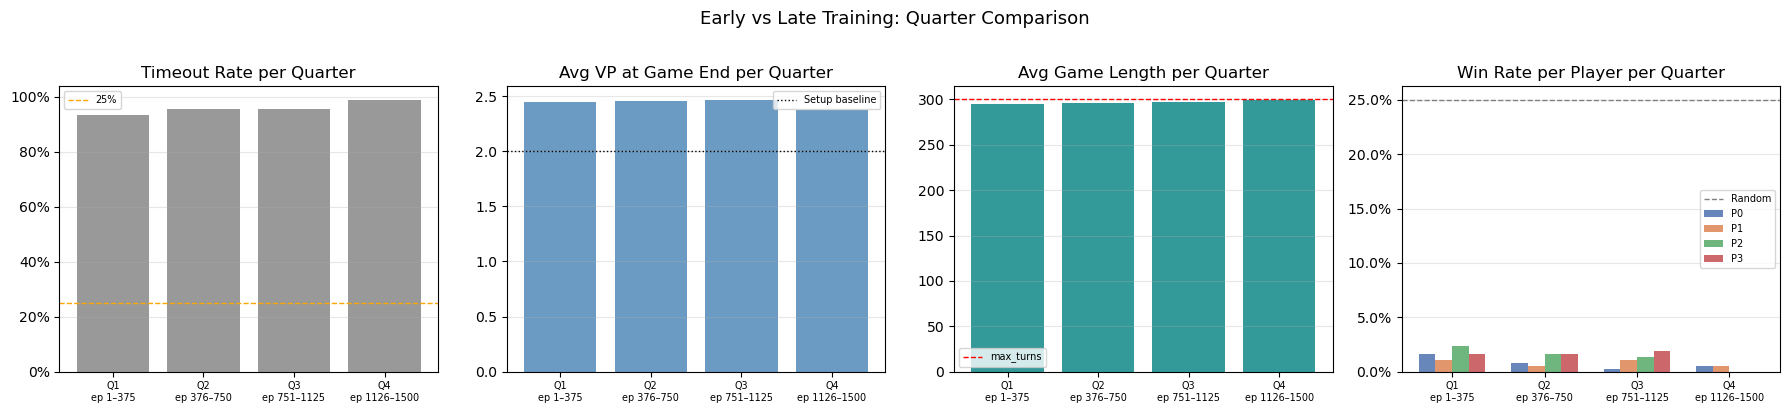


Metric                       Q1       Q2       Q3       Q4         Trend
----------------------------------------------------------------------
Timeout Rate           93.3%  95.5%  95.5%  98.9%       ↑ WORSE
Avg VP                 2.45  2.46  2.47  2.38       ↓ WORSE
Avg Turns              295  296  297  299       ↑ WORSE
Entropy                4.7726  4.2717  4.2149  4.0617       ↓ WORSE


In [24]:
NUM_QUARTERS = 4
q_size = N // NUM_QUARTERS
quarters_range = [(q * q_size, min((q + 1) * q_size, N)) for q in range(NUM_QUARTERS)]
q_labels = [f"Q{q+1}\nep {a+1}–{b}" for q, (a, b) in enumerate(quarters_range)]

def q_slice(arr, a, b):
    return np.asarray(arr)[a:b]

# Compute per-quarter stats
q_timeout   = [q_slice(win_buf, a, b).tolist().count(-1) / (b - a)
               for a, b in quarters_range]
q_vp        = [np.mean([q_slice(vp_buf[i], a, b).mean() for i in range(NUM_PLAYERS)])
               for a, b in quarters_range]
q_turns     = [q_slice(turn_buf, a, b).mean() for a, b in quarters_range]
q_entropy   = [q_slice(entropy_arr, a, b).mean() for a, b in quarters_range]
q_winrate   = [[q_slice(win_buf, a, b).tolist().count(i) / (b - a)
                for i in range(NUM_PLAYERS)]
               for a, b in quarters_range]

x_q = np.arange(NUM_QUARTERS)
bar_w = 0.18

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Timeout rate
axes[0].bar(x_q, q_timeout, color="grey", alpha=0.8)
axes[0].set_title("Timeout Rate per Quarter")
axes[0].set_xticks(x_q)
axes[0].set_xticklabels(q_labels, fontsize=7)
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axes[0].axhline(0.25, color="orange", linestyle="--", linewidth=1, label="25%")
axes[0].legend(fontsize=7)
axes[0].grid(axis="y", alpha=0.3)

# Avg VP
axes[1].bar(x_q, q_vp, color="steelblue", alpha=0.8)
axes[1].axhline(2, color="black", linestyle=":", linewidth=1, label="Setup baseline")
axes[1].set_title("Avg VP at Game End per Quarter")
axes[1].set_xticks(x_q)
axes[1].set_xticklabels(q_labels, fontsize=7)
axes[1].legend(fontsize=7)
axes[1].grid(axis="y", alpha=0.3)

# Avg turns
axes[2].bar(x_q, q_turns, color="teal", alpha=0.8)
axes[2].axhline(300, color="red", linestyle="--", linewidth=1, label="max_turns")
axes[2].set_title("Avg Game Length per Quarter")
axes[2].set_xticks(x_q)
axes[2].set_xticklabels(q_labels, fontsize=7)
axes[2].legend(fontsize=7)
axes[2].grid(axis="y", alpha=0.3)

# Win rate per player per quarter (grouped bars)
for i in range(NUM_PLAYERS):
    axes[3].bar(x_q + i * bar_w, [q_winrate[q][i] for q in range(NUM_QUARTERS)],
                width=bar_w, color=COLORS[i], label=f"P{i}", alpha=0.85)
axes[3].set_title("Win Rate per Player per Quarter")
axes[3].set_xticks(x_q + bar_w * (NUM_PLAYERS - 1) / 2)
axes[3].set_xticklabels(q_labels, fontsize=7)
axes[3].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
axes[3].axhline(0.25, color="grey", linestyle="--", linewidth=1, label="Random")
axes[3].legend(fontsize=7)
axes[3].grid(axis="y", alpha=0.3)

plt.suptitle("Early vs Late Training: Quarter Comparison", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Trend summary
print(f"\n{'Metric':<22} {'Q1':>8} {'Q2':>8} {'Q3':>8} {'Q4':>8}  {'Trend':>12}")
print("-" * 70)
for name, vals, fmt in [
    ("Timeout Rate",  q_timeout, "{:.1%}"),
    ("Avg VP",        q_vp,      "{:.2f}"),
    ("Avg Turns",     q_turns,   "{:.0f}"),
    ("Entropy",       q_entropy, "{:.4f}"),
]:
    trend = "↑ BETTER" if vals[-1] > vals[0] else "↓ WORSE"
    if name in ("Timeout Rate", "Avg Turns"):
        trend = "↓ BETTER" if vals[-1] < vals[0] else "↑ WORSE"
    cols = "  ".join(fmt.format(v) for v in vals)
    print(f"{name:<22} {cols}  {trend:>12}")

## 9 · VP & Timeout Rate — Dual-Axis Trend
These two metrics should move in opposite directions as agents improve. If they move together (VP down, timeout up), agents are converging to a **passive / do-nothing strategy**.

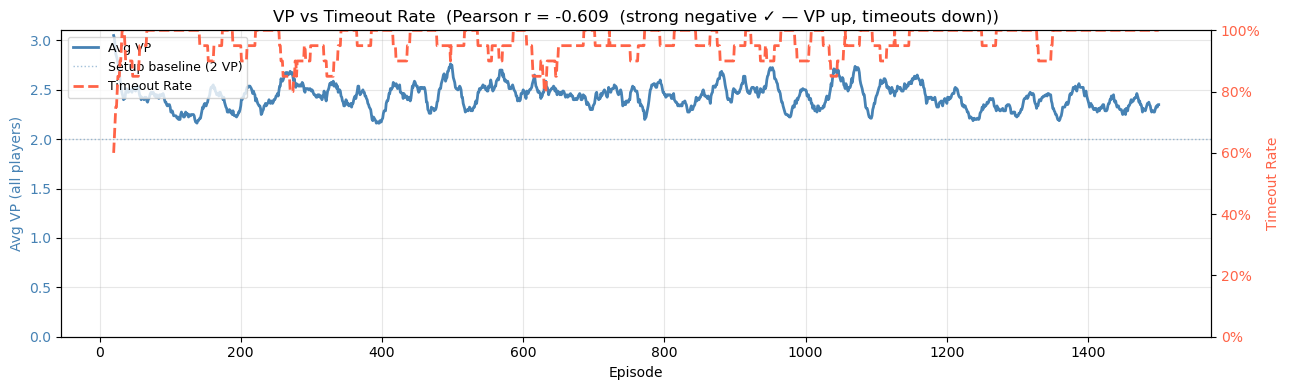

In [25]:
mean_vp_per_ep  = np.mean([np.array(vp_buf[i], dtype=float) for i in range(NUM_PLAYERS)], axis=0)
timeout_per_ep  = np.array([1.0 if w == -1 else 0.0 for w in win_buf])

s_vp  = smooth(mean_vp_per_ep, SMOOTH)
s_to  = smooth(timeout_per_ep, SMOOTH)
x_s   = eps[SMOOTH - 1:]

fig, ax1 = plt.subplots(figsize=(13, 4))
color_vp = "steelblue"
color_to = "tomato"

ax1.set_xlabel("Episode")
ax1.set_ylabel("Avg VP (all players)", color=color_vp)
ax1.plot(x_s, s_vp, color=color_vp, linewidth=2, label="Avg VP")
ax1.axhline(2, color=color_vp, linestyle=":", linewidth=1, alpha=0.5, label="Setup baseline (2 VP)")
ax1.tick_params(axis="y", labelcolor=color_vp)
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.set_ylabel("Timeout Rate", color=color_to)
ax2.plot(x_s, s_to, color=color_to, linewidth=2, linestyle="--", label="Timeout Rate")
ax2.tick_params(axis="y", labelcolor=color_to)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax2.set_ylim(0, 1)

# Pearson correlation (smoothed)
corr = np.corrcoef(s_vp, s_to)[0, 1]
corr_label = (f"Pearson r = {corr:.3f}  "
              + ("(strong negative ✓ — VP up, timeouts down)"     if corr < -0.3
                 else ("(strong positive ⚠ — VP and timeouts move together)" if corr > 0.3
                       else "(weak / no correlation)")))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", fontsize=9)

ax1.set_title(f"VP vs Timeout Rate  ({corr_label})")
ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10 · Automated Diagnosis
Programmatically checks all key signals and prints a prioritised list of issues with suggested fixes.

In [26]:
issues   = []   # (severity, tag, description, fix)
ok_lines = []

EARLY = max(1, N // 5)       # first 20 %
LATE  = max(1, N // 5)       # last  20 %

# ── helpers ───────────────────────────────────────────────────────────
def mean_slice(arr, start, end):
    return float(np.mean(np.asarray(arr)[start:end]))

# ── 1. Entropy collapse ───────────────────────────────────────────────
ent_late  = mean_slice(loss_buf["entropy"], -LATE, N)
ent_early = mean_slice(loss_buf["entropy"], 0, EARLY)

if ent_late < 0.5:
    issues.append(("CRITICAL", "ENTROPY_COLLAPSED",
        f"Entropy in last {LATE} eps = {ent_late:.4f} (was {ent_early:.4f} early)",
        "Raise entropy_coef (e.g. 0.05 → 0.10–0.15).  "
        "Also confirm action masking is not zeroing all but one action."))
elif ent_late < 1.0:
    issues.append(("WARNING", "ENTROPY_LOW",
        f"Entropy in last {LATE} eps = {ent_late:.4f} (was {ent_early:.4f} early)",
        "Entropy is below 1.0 — policy is becoming over-deterministic.  "
        "Consider raising entropy_coef slightly (e.g. 0.05 → 0.08)."))
else:
    ok_lines.append(f"Entropy = {ent_late:.4f}  ✓  (above 1.0 collapse threshold)")

# ── 2. VP trend ────────────────────────────────────────────────────────
vp_early = mean_slice([np.mean([vp_buf[i][ep] for i in range(NUM_PLAYERS)])
                       for ep in range(N)], 0, EARLY)
vp_late  = mean_slice([np.mean([vp_buf[i][ep] for i in range(NUM_PLAYERS)])
                       for ep in range(N)], -LATE, N)
vp_delta = vp_late - vp_early

if vp_delta < -0.3:
    issues.append(("CRITICAL", "VP_DECREASING",
        f"Avg VP dropped {vp_delta:.2f} (early={vp_early:.2f} → late={vp_late:.2f})",
        "Agents are building LESS over time — convergence to a passive strategy.  "
        "Likely cause: invalid-action penalty (-0.01) dominates; agents learn to skip "
        "build actions entirely.  "
        "Fixes: (a) remove the invalid-action penalty, (b) add a per-turn 'did-nothing' "
        "penalty (-0.01 each turn to discourage pure passing), "
        "(c) add small shaped rewards for placing roads/settlements."))
elif vp_delta < 0:
    issues.append(("WARNING", "VP_FLAT_OR_SLIGHTLY_DOWN",
        f"Avg VP slightly down: early={vp_early:.2f} → late={vp_late:.2f}",
        "VP is not improving.  Consider adding richer shaping rewards for building."))
else:
    ok_lines.append(f"Avg VP trend = +{vp_delta:.2f}  ✓  (improving)")

# ── 3. Timeout rate trend ─────────────────────────────────────────────
to_early = sum(1 for w in win_buf[:EARLY]  if w == -1) / EARLY
to_late  = sum(1 for w in win_buf[-LATE:]  if w == -1) / LATE
to_delta = to_late - to_early

if to_late > 0.5:
    issues.append(("CRITICAL", "HIGH_TIMEOUT",
        f"Timeout rate in last {LATE} eps = {to_late:.1%} (was {to_early:.1%} early)",
        "More than half of games time out — agents are not converging to winning.  "
        "This combined with decreasing VP strongly points to passive strategy collapse.  "
        "Consider reducing max_turns to 150 to force more decisive play, and/or "
        "add a small per-step survival penalty (e.g. -0.001) to discourage long games."))
elif to_delta > 0.15:
    issues.append(("WARNING", "TIMEOUT_INCREASING",
        f"Timeout rate rising: early={to_early:.1%} → late={to_late:.1%}",
        "Games are getting longer, not shorter.  "
        "Lower max_turns or add a small step penalty: -0.001 per turn."))
else:
    ok_lines.append(f"Timeout rate = {to_late:.1%}  ✓  (not increasing)")

# ── 4. VP–timeout anti-correlation ───────────────────────────────────
corr_vp_to = np.corrcoef(smooth(mean_vp_per_ep, SMOOTH),
                          smooth(timeout_per_ep, SMOOTH))[0, 1]
if corr_vp_to > 0.3:
    issues.append(("CRITICAL", "PASSIVE_STRATEGY",
        f"VP and timeout move TOGETHER (Pearson r = {corr_vp_to:.3f})",
        "Both metrics trending the same direction is the signature of a passive strategy: "
        "as agents get more deterministic, they build less AND time out more.  "
        "This is the core failure mode — not a local minimum, but a degenerate one."))
else:
    ok_lines.append(f"VP-timeout correlation = {corr_vp_to:.3f}  ✓  (moving in opposite directions)")

# ── 5. Win-rate collapse (all timeouts) ───────────────────────────────
total_wins_late = [sum(1 for w in win_buf[-LATE:] if w == i) for i in range(NUM_PLAYERS)]
any_winner = sum(total_wins_late) > 0
if not any_winner:
    issues.append(("CRITICAL", "NO_WINS",
        f"Zero decisive wins in the last {LATE} episodes (all timeouts)",
        "Agents have completely stopped winning.  Reduce max_turns drastically "
        "(e.g. 150 or even 100) so some games naturally end, and the +1.0 win "
        "reward can be seen."))
else:
    ok_lines.append(f"At least one winner in last {LATE} eps  ✓")

# ── 6. Value loss ─────────────────────────────────────────────────────
vloss_late = mean_slice(loss_buf["value"], -LATE, N)
if vloss_late > 5.0:
    issues.append(("WARNING", "HIGH_VALUE_LOSS",
        f"Value loss = {vloss_late:.4f} (high — value head struggling)",
        "Increase value_coef (e.g. 0.5 → 1.0) or slow the learning rate."))
else:
    ok_lines.append(f"Value loss = {vloss_late:.4f}  ✓")

# ── Print report ───────────────────────────────────────────────────────
SEV_ORDER = {"CRITICAL": 0, "WARNING": 1}
issues.sort(key=lambda x: SEV_ORDER[x[0]])

print("=" * 72)
print("  TRAINING DIAGNOSIS REPORT")
print(f"  {N} total episodes   |   last {LATE} eps used for 'late' stats")
print("=" * 72)

if not issues:
    print("\n  ✓  No issues detected — training looks healthy.\n")
else:
    for sev, tag, desc, fix in issues:
        badge = "🔴 CRITICAL" if sev == "CRITICAL" else "🟡 WARNING"
        print(f"\n{badge}  [{tag}]")
        print(f"    Observation : {desc}")
        print(f"    Suggested fix: {fix}")

print("\n── Passing checks ─────────────────────────────────────────────")
for line in ok_lines:
    print(f"  ✅  {line}")
print("=" * 72)

  TRAINING DIAGNOSIS REPORT
  1500 total episodes   |   last 300 eps used for 'late' stats

🔴 CRITICAL  [HIGH_TIMEOUT]
    Observation : Timeout rate in last 300 eps = 99.0% (was 93.0% early)
    Suggested fix: More than half of games time out — agents are not converging to winning.  This combined with decreasing VP strongly points to passive strategy collapse.  Consider reducing max_turns to 150 to force more decisive play, and/or add a small per-step survival penalty (e.g. -0.001) to discourage long games.

🟡 WARNING  [VP_FLAT_OR_SLIGHTLY_DOWN]
    Observation : Avg VP slightly down: early=2.45 → late=2.35
    Suggested fix: VP is not improving.  Consider adding richer shaping rewards for building.

── Passing checks ─────────────────────────────────────────────
  ✅  Entropy = 4.0810  ✓  (above 1.0 collapse threshold)
  ✅  VP-timeout correlation = -0.609  ✓  (moving in opposite directions)
  ✅  At least one winner in last 300 eps  ✓
  ✅  Value loss = 0.0090  ✓
